In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import fiona
import numpy as np
import cartopy
import matplotlib
import cartopy.crs as ccrs
from geopy.distance import geodesic
from shapely.ops import nearest_points

plt.style.use("ggplot")

In [13]:
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# 1000 Lakes 2019 (Part 1: Linking Aquamonitor to RESA2)

Now that most/all analyses are complete, we want to link the data in Aquamnonitor to RESA, and do some cleaning & checking in the process.

## 1. Check existing AM - RESA links

Most of the 2019 lakes have been sampled previously in 1995, so connections already exist in most cases. These need checking.

### 1.1. Match AM IDs to RESA

In [4]:
# Read latest station details from AM
am_xls = r"../../1000_Lakes_AM_Export_2020-05-14.xlsx"
am_df = pd.read_excel(am_xls, sheet_name="StationPoint")
am_df = am_df[["StationId", "StationCode", "StationName", "Latitude", "Longitude"]]
am_df.columns = ["am_id", "am_code", "am_name", "am_lat", "am_lon"]

print(len(am_df["am_id"].unique()), "stations in AM.")

am_df.head()

1002 stations in AM.


,am_id,am_code,am_name,am_lat,am_lon
0,26070,221-1-2,Langtjern,59.808643,11.850274
1,26071,101-2-7,Hokksjøen,59.004423,11.563586
2,26072,402-2-13,Sætertjern,60.060222,12.446711
3,26073,419-1-25,Mjøgsjøen,60.328578,11.842186
4,26074,425-2-2,Kottern,60.590729,12.517008


In [4]:
# Get RESA IDs for these stations where links already exist
bind_stns = ",".join("(1, %d)" % i for i in am_df["am_id"].unique())
sql = (
    "SELECT station_id as am_id, "
    "  local_pk as resa_id "
    " FROM nivadatabase.datasource_station "
    "WHERE datasource_id = 11 "
    "AND (1, station_id) in (%s)" % bind_stns
)
df = pd.read_sql(sql, eng)

print(len(df), "stations are already linked to RESA.")

df.head()

981 stations are already linked to RESA.


,am_id,resa_id
0,46105,17957
1,46120,18073
2,46323,17854
3,46550,18013
4,46620,17809


In [5]:
# Get details for matching stations in RESA
resa_df = nivapy.da.select_resa_stations(eng)
resa_df = resa_df.query("station_id in @df.resa_id.unique()")

resa_df = resa_df[
    ["station_id", "station_code", "station_name", "latitude", "longitude"]
]
resa_df.columns = ["resa_id", "resa_code", "resa_name", "resa_lat", "resa_lon"]

print(len(resa_df), "matching stations found in RESA.")

resa_df.head()

19688 stations in the RESA database.
981 matching stations found in RESA.


,resa_id,resa_code,resa_name,resa_lat,resa_lon
5,9,101-2-7,Hokksjøen,59.004421,11.563584
6,10,221-1-2,Langtjern,59.808647,11.850279
7,11,402-2-13,Sætertjern,60.060220,12.446706
8,12,419-1-25,Mjøgsjøen,60.328576,11.842177
9,13,425-2-2,Kottern,60.590732,12.517008


In [6]:
# Merge results
df = pd.merge(am_df, df, how="left", on="am_id")
df = pd.merge(df, resa_df, how="left", on="resa_id")

print(df["resa_id"].isna().sum(), "stations in AM are not yet linked to RESA.")
print(
    df["resa_lat"].isna().sum(),
    "stations in RESA do not have complete co-ordinate information.",
)

df.head()

21 stations in AM are not yet linked to RESA.
25 stations in RESA do not have complete co-ordinate information.


,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon
0,26070,221-1-2,Langtjern,59.808643,11.850274,10.0,221-1-2,Langtjern,59.808647,11.850279
1,26071,101-2-7,Hokksjøen,59.004423,11.563586,9.0,101-2-7,Hokksjøen,59.004421,11.563584
2,26072,402-2-13,Sætertjern,60.060222,12.446711,11.0,402-2-13,Sætertjern,60.060220,12.446706
3,26073,419-1-25,Mjøgsjøen,60.328578,11.842186,12.0,419-1-25,Mjøgsjøen,60.328576,11.842177
4,26074,425-2-2,Kottern,60.590729,12.517008,13.0,425-2-2,Kottern,60.590732,12.517008


### 1.2. Compare AM and RESA co-ordinates

In [7]:
def f(row):
    """ Calculate geodesic distance between locations in AM and RESA.
    """
    am_coords = (row["am_lat"], row["am_lon"])
    resa_coords = (row["resa_lat"], row["resa_lon"])
    return geodesic(am_coords, resa_coords).meters

In [8]:
# Add distances between points in AM and RESA
coord_df = df.dropna(subset=["am_lat", "am_lon", "resa_lat", "resa_lon"])
coord_df["distance_m"] = coord_df.apply(f, axis=1)

coord_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon,distance_m
0,26070,221-1-2,Langtjern,59.808643,11.850274,10.0,221-1-2,Langtjern,59.808647,11.850279,0.566628
1,26071,101-2-7,Hokksjøen,59.004423,11.563586,9.0,101-2-7,Hokksjøen,59.004421,11.563584,0.316569
2,26072,402-2-13,Sætertjern,60.060222,12.446711,11.0,402-2-13,Sætertjern,60.060220,12.446706,0.388633
3,26073,419-1-25,Mjøgsjøen,60.328578,11.842186,12.0,419-1-25,Mjøgsjøen,60.328576,11.842177,0.547998
4,26074,425-2-2,Kottern,60.590729,12.517008,13.0,425-2-2,Kottern,60.590732,12.517008,0.263258


### 1.3. Compare AM and RESA lake IDs from NVE

In [9]:
# Get layers in NVE lakes GDB
gdb_path = r"../../NVEData.gdb"
layer_list = fiona.listlayers(gdb_path)
print(layer_list)

['Innsjo']


In [10]:
# Read lakes dataset
gdf = gpd.read_file(gdb_path, layer="Innsjo")

# Link AM coords to lakes
coord_df = nivapy.spatial.identify_point_in_polygon(
    coord_df,
    gdf,
    pt_col="am_id",
    poly_col="vatnLnr",
    lat_col="am_lat",
    lon_col="am_lon",
)

# Join NVE name
coord_df = pd.merge(coord_df, gdf[["vatnLnr", "navn"]], how="left", on="vatnLnr")

coord_df.rename({"vatnLnr": "am_nve_id", "navn": "am_nve_name"}, axis=1, inplace=True)

# Link RESA coords to lakes
coord_df = nivapy.spatial.identify_point_in_polygon(
    coord_df,
    gdf,
    pt_col="resa_id",
    poly_col="vatnLnr",
    lat_col="resa_lat",
    lon_col="resa_lon",
)

# Join NVE name
coord_df = pd.merge(coord_df, gdf[["vatnLnr", "navn"]], how="left", on="vatnLnr")

coord_df.rename(
    {"vatnLnr": "resa_nve_id", "navn": "resa_nve_name"}, axis=1, inplace=True
)

coord_df.head()

,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon,distance_m,am_nve_id,am_nve_name,resa_nve_id,resa_nve_name
0,26070,221-1-2,Langtjern,59.808643,11.850274,10.0,221-1-2,Langtjern,59.808647,11.850279,0.566628,3208.0,Langtjenn,3208.0,Langtjenn
1,26071,101-2-7,Hokksjøen,59.004423,11.563586,9.0,101-2-7,Hokksjøen,59.004421,11.563584,0.316569,3608.0,Hokksjøen,3608.0,Hokksjøen
2,26072,402-2-13,Sætertjern,60.060222,12.446711,11.0,402-2-13,Sætertjern,60.060220,12.446706,0.388633,4332.0,Sætertjenn,4332.0,Sætertjenn
3,26073,419-1-25,Mjøgsjøen,60.328578,11.842186,12.0,419-1-25,Mjøgsjøen,60.328576,11.842177,0.547998,4055.0,Mjøgsjøen,4055.0,Mjøgsjøen
4,26074,425-2-2,Kottern,60.590729,12.517008,13.0,425-2-2,Kottern,60.590732,12.517008,0.263258,3794.0,Kottern,3794.0,Kottern


## 2. Quality assess existing AM - RESA links

### 2.1. Identify inconsistent stations

In [11]:
# Stations where codes don't match
coord_df.query("am_code != resa_code")

,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon,distance_m,am_nve_id,am_nve_name,resa_nve_id,resa_nve_name
119,26199,419-3-2,Storbørja,60.091,11.912,191.0,402-604,Storbørja,60.091292,11.927417,858.498227,368.0,Storbørja,NaN,NaN


In [12]:
# Stations where NVE lake IDs don't match
coord_df.query("am_nve_id != resa_nve_id").dropna(subset=["resa_nve_id"])

,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon,distance_m,am_nve_id,am_nve_name,resa_nve_id,resa_nve_name
109,26186,402-1-28,Eintjern,60.072400,12.368182,3027.0,402-1-28,Eintjenn,60.074,12.345,1302.937084,4321.0,Eintjenn,4313.0,Kolbjørnsrudsjøen
328,26423,912-2-27,Ljøsvannet,61.132430,10.870015,3280.0,912-2-27,Ljøsvannet,58.757,8.901,286588.882538,33055.0,Store Ljøsvatnet,9183.0,Ljøsvannet
709,26821,1740-2-9,Storskorovatn,64.647186,13.060158,3707.0,1740-2-9,Storskorovatn,64.670,13.024,3074.629718,39432.0,Storskorovatnet,39394.0,Åttatjønna
748,26860,1836-2-14,Storvatnet,66.656207,13.226925,3749.0,1836-2-14,Storevatnet,66.663,13.247,1167.165665,44357.0,Storvatnet,44350.0,Litlvatnet
770,26882,1854-2-16,Stopålvatnet,68.362866,16.590626,3772.0,1854-2-16,Storpålvatnet,68.370,16.646,2414.065290,48666.0,Stopålvatnet,48662.0,Holmvatnet
944,27064,1825-1-9,Sivtjønna,65.176841,13.240496,3735.0,1825-1-9,Sivtjørna,65.179,13.252,590.397703,43247.0,Sivtjønna,43245.0,None


In [13]:
# Stations where NVE lake IDs don't match because resa_nve_id is NaN
coord_df.query(
    "(am_nve_id != resa_nve_id) and (resa_nve_id != resa_nve_id)"
).sort_values("distance_m", ascending=False)

,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon,distance_m,am_nve_id,am_nve_name,resa_nve_id,resa_nve_name
962,45671,2030-623,St. Sametti,69.471997,29.632787,15860.0,2030-623,ST.SAMETTI,69.488029,27.084386,99743.917606,2447.0,Sámetjávri,NaN,NaN
300,26390,829-4-6,Kviteseidvatnet,59.349741,8.580646,3244.0,829-4-6,Kviteseidvatnet,59.382000,8.465000,7494.002681,8.0,Kviteseidvatnet,NaN,NaN
900,27014,1711-3-1,Skurdalsvatnet,63.364094,12.090835,3918.0,1711-3-1,Skurdalsvatnet,63.372000,12.122000,1791.074048,736.0,Skurdalssjøen,NaN,NaN
202,26286,545-4-1,Bygdin,61.363000,8.386000,3134.0,545-4-1,Bygdin,61.349816,8.399882,1646.212866,146.0,Bygdin,NaN,NaN
75,26151,1640-603,Tufsingen,62.606772,11.894180,116.0,1640-603,Tufsingen,62.612294,11.876558,1094.271435,35326.0,Tufsingen,NaN,NaN
498,26606,1228-1-12,HOH 1367,60.028612,6.822722,3474.0,1228-1-12,HOH 1367,60.029401,6.840693,1005.730756,27782.0,None,NaN,NaN
119,26199,419-3-2,Storbørja,60.091000,11.912000,191.0,402-604,Storbørja,60.091292,11.927417,858.498227,368.0,Storbørja,NaN,NaN
74,26150,831-501,Brårvatn,59.297470,7.714567,115.0,831-501,Brårvatn,59.294921,7.727118,769.458227,14277.0,Brårvatn,NaN,NaN
76,26152,1228-501,Steinavatn,59.856352,6.571981,135.0,1228-501,Steinavatn,59.859877,6.578783,547.361873,1705.0,Steinavatnet,NaN,NaN
956,27076,1640-3-7,Midtre Muggsjøen,62.438933,12.172615,3917.0,1640-3-7,Midtre Muggsjøen,62.441000,12.180000,445.589577,1360.0,Midtre Muggsjøen,NaN,NaN


### 2.2. Map inconsistent sites

In [14]:
# All sites where code or NVE IDs do not match
err_df = coord_df.query("(am_code != resa_code) or (am_nve_id != resa_nve_id)")
err_df.to_csv(r"../../stations_with_errors_18-05-2020.csv")

# Convert co-ords to UTM Zone 33N
# AM
err_df = nivapy.spatial.wgs84_dd_to_utm(err_df, lat="am_lat", lon="am_lon")
err_df.rename({"utm_north": "am_north", "utm_east": "am_east"}, axis=1, inplace=True)

# RESA
err_df = nivapy.spatial.wgs84_dd_to_utm(err_df, lat="resa_lat", lon="resa_lon")
err_df.rename(
    {"utm_north": "resa_north", "utm_east": "resa_east"}, axis=1, inplace=True
)

err_df.head()

,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon,distance_m,am_nve_id,am_nve_name,resa_nve_id,resa_nve_name,am_north,am_east,utm_zone,resa_north,resa_east
16,26087,604-3-3,Hengsvatnet,59.656185,9.441521,26.0,604-3-3,Hengsvatnet,59.656902,9.443625,143.010561,398.0,Hengsvannet,NaN,NaN,6.626241e+06,186990.580571,33,6.626311e+06,187115.547496
37,26110,1201-1-23,Knappatjørna,60.329958,5.262102,53.0,1201-1-23,HOH 60,60.329992,5.262997,49.602367,26786.0,Knappatjørna,NaN,NaN,6.727909e+06,-36411.253686,33,6.727905e+06,-36361.622781
74,26150,831-501,Brårvatn,59.297470,7.714567,115.0,831-501,Brårvatn,59.294921,7.727118,769.458227,14277.0,Brårvatn,NaN,NaN,6.595877e+06,85588.002216,33,6.595516e+06,86269.002008
75,26151,1640-603,Tufsingen,62.606772,11.894180,116.0,1640-603,Tufsingen,62.612294,11.876558,1094.271435,35326.0,Tufsingen,NaN,NaN,6.945615e+06,340615.000056,33,6.946273e+06,339740.999859
76,26152,1228-501,Steinavatn,59.856352,6.571981,135.0,1228-501,Steinavatn,59.859877,6.578783,547.361873,1705.0,Steinavatnet,NaN,NaN,6.665470e+06,28716.007085,33,6.665812e+06,29145.007789


In [15]:
def chunker(df, size):
    """ Split a dataframe into chunks of length 'size'.
    """
    return (df[pos : pos + size] for pos in range(0, len(df), size))

In [16]:
# Size of square buffer around monitoring points
buff = 500

# Loop over chunks
for df_idx, df_part in enumerate(chunker(err_df.reset_index(drop=True), 20)):
    fig = plt.figure(figsize=(15, 20))

    # Loop over stations
    for idx, row in df_part.reset_index(drop=True).iterrows():
        zone = row["utm_zone"]
        am_north = row["am_north"]
        am_east = row["am_east"]
        resa_north = row["resa_north"]
        resa_east = row["resa_east"]

        # Get bounding box
        xmin = min(resa_east, am_east)
        xmax = max(resa_east, am_east)
        ymin = min(resa_north, am_north)
        ymax = max(resa_north, am_north)

        # Define co-ord system
        crs = ccrs.UTM(zone)

        # Plot
        ax = fig.add_subplot(5, 4, idx + 1, projection=crs)
        ax.set_extent([xmin - buff, xmax + buff, ymin - buff, ymax + buff], crs=crs)

        ax.add_wms(
            wms="https://openwms.statkart.no/skwms1/wms.topo4", layers=["topo4_WMS"]
        )

        ax.scatter(am_east, am_north, s=50, c="r", edgecolors="k", transform=crs)
        ax.scatter(
            resa_east, resa_north, s=50, c="yellow", edgecolors="k", transform=crs
        )

        ax.set_title(
            f"AM code {row['am_code']}\nSeparation: {int(row['distance_m'])} m",
            fontsize=12,
        )

    # Save
    out_png = r"../../grid_maps/resa_am_mismatch/grid_plot_%03d.png" % (df_idx + 1)
    plt.savefig(out_png, dpi=150)
    plt.clf()
    plt.close()

## 3. Making new AM - RESA linkages

### 3.1. Check whether stations already exist in RESA

In [17]:
# Get stations that need linking
nolink_df = df[df["resa_id"].isna()]
nolink_df = nolink_df[["am_id", "am_code", "am_name", "am_lat", "am_lon"]]
print(len(nolink_df), "stations in AM are not yet linked to RESA.")
nolink_df

21 stations in AM are not yet linked to RESA.


,am_id,am_code,am_name,am_lat,am_lon
981,71071,620-502,Storekrækkja,60.442327,7.766306
982,71072,938-3-4,Storolavsvatnet,58.858337,7.275763
983,71073,402-3-9,N Hærsjøen,60.114995,12.380999
984,71074,403-3-15,Brumundsjøen,61.026999,11.111989
985,71075,540-3-13,Nevlingen,60.537266,9.463916
986,71076,1133-2-16,Holmavatnet,59.257026,6.667323
987,71077,1134-3-6,Kaldevatn,59.490591,6.796072
988,71078,1224-3-12,Myrdalsvatnet,60.035054,6.082931
989,71079,1421-3-13,Store Liavatnet,60.863996,7.636987
990,71080,1525-3-7,Vatnedalsvatnet,62.003995,6.896984


#### 3.1.1. Attempt to match by station code

In [18]:
# Get all stations in RESA
resa_df = nivapy.da.select_resa_stations(eng)
resa_df = resa_df[
    ["station_id", "station_code", "station_name", "latitude", "longitude"]
]
resa_df.columns = ["resa_id", "resa_code", "resa_name", "resa_lat", "resa_lon"]

# Try linking by codes
nolink_codes = list(nolink_df["am_code"].unique())
inresa_df = resa_df.query("resa_code in @nolink_codes")

inresa_df = pd.merge(
    nolink_df, inresa_df, how="inner", left_on="am_code", right_on="resa_code"
)

inresa_df

19688 stations in the RESA database.


,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon
0,71071,620-502,Storekrækkja,60.442327,7.766306,137,620-502,Storekrækkja,60.439000,7.784000
1,71072,938-3-4,Storolavsvatnet,58.858337,7.275763,39,938-3-4,Storolavsvatnet,58.859362,7.262579
2,71073,402-3-9,N Hærsjøen,60.114995,12.380999,3030,402-3-9,N Hærsjøen,60.115000,12.381000
3,71074,403-3-15,Brumundsjøen,61.026999,11.111989,3031,403-3-15,Brumundsjøen,61.027000,11.112000
4,71075,540-3-13,Nevlingen,60.537266,9.463916,23,540-3-13,Nevlingen,60.537266,9.463916
5,71076,1133-2-16,Holmavatnet,59.257026,6.667323,3433,1133-2-16,Holmavatnet,59.257026,6.667323
6,71077,1134-3-6,Kaldevatn,59.490591,6.796072,3440,1134-3-6,Kaldevatn,59.490591,6.796072
7,71078,1224-3-12,Myrdalsvatnet,60.035054,6.082931,3473,1224-3-12,Myrdalsvatnet,60.035055,6.082931
8,71079,1421-3-13,Store Liavatnet,60.863996,7.636987,3544,1421-3-13,Store Liavatnet,60.864000,7.637000
9,71080,1525-3-7,Vatnedalsvatnet,62.003995,6.896984,3599,1525-3-7,Vatnedalsvatnet,62.004000,6.897000


It appears that 15 of the stations can be correctly matched by `station_code`.

#### 3.1.2. Attempt to match by station proximity

For the remaining 6, I'll find the closest station in RESA (to see if codes are different).

In [19]:
match_stns = list(inresa_df["am_id"].unique())
nomatch_df = nolink_df.query("am_id not in @match_stns")
nomatch_df

,am_id,am_code,am_name,am_lat,am_lon
995,71716,128-2-200,Langevatnet,59.463667,11.484320
996,71717,402-2-201,Damtjenn,60.337595,12.113840
997,71718,428-2-202,Gløtsjøen,61.541646,12.117062
999,71723,938-3-203,Gyvatn,58.729637,7.663584
1000,71725,1432-2-205,Femtevatnet,61.480663,6.626382
1001,71862,1001-2-204,Vassvann,58.139413,8.154880


In [20]:
# Build geodataframes
nomatch_gdf = gpd.GeoDataFrame(
    nomatch_df,
    crs={"init": "epsg:4326"},
    geometry=gpd.points_from_xy(nomatch_df["am_lon"], nomatch_df["am_lat"]),
).to_crs({"init": "epsg:32633"})

resa_gdf = gpd.GeoDataFrame(
    resa_df,
    crs={"init": "epsg:4326"},
    geometry=gpd.points_from_xy(resa_df["resa_lon"], resa_df["resa_lat"]),
).to_crs({"init": "epsg:32633"})

In [21]:
def near(point, pts):
    """ Find the nearest location in 'pts' to 'point'. From

            https://gis.stackexchange.com/a/222388/2131
    """
    nearest = resa_gdf.geometry == nearest_points(point, pts)[1]
    return resa_gdf[nearest].resa_id.array[0]


# Unary union of RESA geomtries
pts = resa_gdf.geometry.unary_union

# Add RESA ID for nearest site
nomatch_gdf["resa_id"] = nomatch_gdf.apply(lambda row: near(row.geometry, pts), axis=1)

# Join RESA details
nomatch_gdf = pd.merge(nomatch_gdf, resa_df, how="left", on="resa_id")
del nomatch_gdf["geometry_x"], nomatch_gdf["geometry_y"]

nomatch_gdf

,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon
0,71716,128-2-200,Langevatnet,59.463667,11.484320,34714,ØST191,Låstjern,59.470164,11.466922
1,71717,402-2-201,Damtjenn,60.337595,12.113840,32208,HE317NUG,Nugguren,60.306000,12.088000
2,71718,428-2-202,Gløtsjøen,61.541646,12.117062,32217,HE338ENG,Engeren,61.570999,12.046993
3,71723,938-3-203,Gyvatn,58.729637,7.663584,20793,1026-37,Kjosevatn,58.753996,7.653989
4,71725,1432-2-205,Femtevatnet,61.480663,6.626382,3572,1431-3-25,Trollavatnet,61.490000,6.659000
5,71862,1001-2-204,Vassvann,58.139413,8.154880,34880,VAG493,Vassvatnet,58.141375,8.152168


The co-ordinates are very similar, but the lake names are different. The code below plots sketch maps to see whther the lakes in RESA actually do match.

In [22]:
# Convert co-ords to UTM Zone 33N
# AM
nomatch_gdf = nivapy.spatial.wgs84_dd_to_utm(nomatch_gdf, lat="am_lat", lon="am_lon")
nomatch_gdf.rename(
    {"utm_north": "am_north", "utm_east": "am_east"}, axis=1, inplace=True
)

# RESA
nomatch_gdf = nivapy.spatial.wgs84_dd_to_utm(
    nomatch_gdf, lat="resa_lat", lon="resa_lon"
)
nomatch_gdf.rename(
    {"utm_north": "resa_north", "utm_east": "resa_east"}, axis=1, inplace=True
)

nomatch_gdf

,am_id,am_code,am_name,am_lat,am_lon,resa_id,resa_code,resa_name,resa_lat,resa_lon,am_north,am_east,utm_zone,resa_north,resa_east
0,71716,128-2-200,Langevatnet,59.463667,11.484320,34714,ØST191,Låstjern,59.470164,11.466922,6.596950e+06,300798.742575,33,6.597725e+06,299851.988023
1,71717,402-2-201,Damtjenn,60.337595,12.113840,32208,HE317NUG,Nugguren,60.306000,12.088000,6.692497e+06,340694.004332,33,6.689043e+06,339112.965752
2,71718,428-2-202,Gløtsjøen,61.541646,12.117062,32217,HE338ENG,Engeren,61.570999,12.046993,6.826511e+06,346771.235676,33,6.829945e+06,343197.061364
3,71723,938-3-203,Gyvatn,58.729637,7.663584,20793,1026-37,Kjosevatn,58.753996,7.653989,6.533213e+06,75743.734796,33,6.535975e+06,75488.060455
4,71725,1432-2-205,Femtevatnet,61.480663,6.626382,3572,1431-3-25,Trollavatnet,61.490000,6.659000,6.844985e+06,54832.692014,33,6.845796e+06,56693.217614
5,71862,1001-2-204,Vassvann,58.139413,8.154880,34880,VAG493,Vassvatnet,58.141375,8.152168,6.464696e+06,97390.000821,33,6.464930e+06,97253.023870


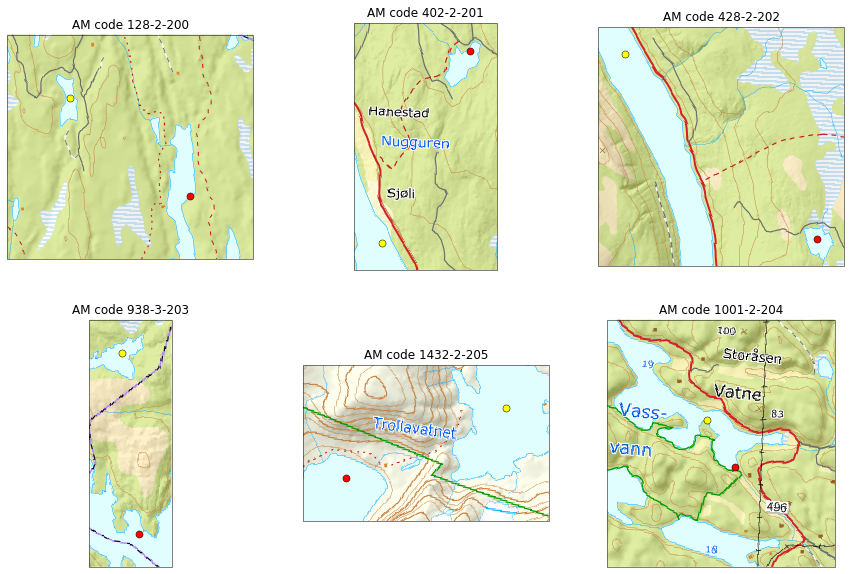

In [23]:
# Maps
buff = 500

fig = plt.figure(figsize=(15, 10))

# Loop over stations
for idx, row in nomatch_gdf.iterrows():
    zone = row["utm_zone"]
    am_north = row["am_north"]
    am_east = row["am_east"]
    resa_north = row["resa_north"]
    resa_east = row["resa_east"]

    # Get bounding box
    xmin = min(resa_east, am_east)
    xmax = max(resa_east, am_east)
    ymin = min(resa_north, am_north)
    ymax = max(resa_north, am_north)

    # Define co-ord system
    crs = ccrs.UTM(zone)

    # Plot
    ax = fig.add_subplot(2, 3, idx + 1, projection=crs)
    ax.set_extent([xmin - buff, xmax + buff, ymin - buff, ymax + buff], crs=crs)

    ax.add_wms(wms="https://openwms.statkart.no/skwms1/wms.topo4", layers=["topo4_WMS"])

    ax.scatter(am_east, am_north, s=50, c="r", edgecolors="k", transform=crs)
    ax.scatter(resa_east, resa_north, s=50, c="yellow", edgecolors="k", transform=crs)

    ax.set_title(
        f"AM code {row['am_code']}", fontsize=12,
    )

In five out of six cases, the RESA co-ordinates refer to completely different lakes. In one case (AM code 1001-2-204) the lake is already present in RESA, However, from a quick check in the database, it is obvious that this RESA station (`VAG493`) has never been part of the 1000 Lakes, so I'll create a new station for this too.

### 3.2. Summary

 * There are 1002 stations in the 2019 1000 Lakes survey
 
 * 981 of these are already in both databases and correctly linked
 
 * A further 15 are present in both databases, but entries in the linking table are missing
 
 * The remaining 6 are not present in RESA and need to be created
 
 * Of the 981 already linked, there are significant issues/inconsistencies with two (see e-mail sent to Atle 14.05.2020 at 15.42)
 
Furthermore, as previously agreed, we will **update co-ordinates, station names, NVE lake IDs, lake elevation and lake area information for all 1002 lakes** based on the information in AM.

## 4. Updating the databases

### 4.1. Add 6 new stations to RESA

In [26]:
# Basic station data
new_df = nomatch_df[["am_code", "am_name", "am_lat", "am_lon"]]
new_df.columns = ["station_code", "station_name", "latitude", "longitude"]
new_df

,station_code,station_name,latitude,longitude
995,128-2-200,Langevatnet,59.463667,11.484320
996,402-2-201,Damtjenn,60.337595,12.113840
997,428-2-202,Gløtsjøen,61.541646,12.117062
999,938-3-203,Gyvatn,58.729637,7.663584
1000,1432-2-205,Femtevatnet,61.480663,6.626382
1001,1001-2-204,Vassvann,58.139413,8.154880


In [29]:
## Add to RESA
# new_df.to_sql(
#    "stations", schema="resa2", con=eng, if_exists="append", index=False,
# )

### 4.2. Link 21 stations to AM

In [35]:
# Get IDs for 21 stations from RESA
resa_df = nivapy.da.select_resa_stations(eng)

link_df = pd.merge(
    nolink_df,
    resa_df[["station_id", "station_code"]],
    how="left",
    left_on="am_code",
    right_on="station_code",
)
# Restructure for AM table
link_df["datasource_id"] = 11
link_df = link_df[["am_id", "datasource_id", "station_id"]]
link_df.columns = ["station_id", "datasource_id", "local_pk"]

assert ~(link_df.isnull().values.any())

link_df

19694 stations in the RESA database.


,station_id,datasource_id,local_pk
0,71071,11,137
1,71072,11,39
2,71073,11,3030
3,71074,11,3031
4,71075,11,23
5,71076,11,3433
6,71077,11,3440
7,71078,11,3473
8,71079,11,3544
9,71080,11,3599


In [36]:
## Add to AM
# link_df.to_sql(
#    "datasource_station", schema="nivadatabase", con=eng, if_exists="append", index=False,
# )

Check all stations are now linked.

In [5]:
# Get RESA IDs for these stations where links already exist
bind_stns = ",".join("(1, %d)" % i for i in am_df["am_id"].unique())
sql = (
    "SELECT station_id as am_id, "
    "  local_pk as resa_id "
    " FROM nivadatabase.datasource_station "
    "WHERE datasource_id = 11 "
    "AND (1, station_id) in (%s)" % bind_stns
)
df = pd.read_sql(sql, eng)

print(len(df), "stations are already linked to RESA.")

df.head()

1002 stations are already linked to RESA.


,am_id,resa_id
0,46105,17957
1,46120,18073
2,46323,17854
3,46550,18013
4,46620,17809


### 4.3. Create RESA2 project

I have created a new project in RESA with the name `Nasjonal Innsjøundersøkelse 2019` (to match AM). This project has ID 4530.

In [ ]:
proj_stn_df = am_df[["station_id", "station_code"]].copy()
proj_stn_df["project_id"] = 4530
proj_stn_df["active"] = "Y"

proj_stn_df.head()

In [ ]:
## Add to RESA
# proj_stn_df.to_sql(
#    "projects_stations",
#    schema="resa2",
#    con=eng,
#    if_exists="append",
#    index=False,
#    method="multi",
#    chunksize=1000,
# )

### 4.4. Correct inconsistencies

One of the inconsistencies listed above is Ljøsvannet. In 1995, samples were taken at Ljøsvannet (`912-2-27`) and recorded correctly in RESA. However, in 2019, it appears there was a mix-up and Store Ljøsvatnet (~290 km away) was sampled instead. I have therefore created a new station (with code `412-2-206`) in both RESA and AM, and asked Roar to transfer the 2019 samples to this new station (see e-mail sent to Roar 25.05.2020 at 15.41 and reply from Veronica received 27.05.2020 at 11.32). I have also added this station to the relevant project in RESA, and linked it in the `DATASOURCE_STATION` table.

The second inconsistency is between Svartbørja and Storbørja. Roar has fixed the problems in AM (see e-mail received 27.05.2020 at 14:31) and I have made the following further adjustments in RESA:

 * Moved three samples collected during 2018 and 2019 from Svartbørja to Storbørja
 
 * Updated RESA method-parameter links (new methods were missing)

### 4.5. Update details for all 1003 stations

Having made the changes described above, I have exported the latest version of the data from AM. This will be used to update station details in RESA.

In [32]:
# Read station details from AM
am_xls = r"../../../1000_Lakes_AM_Export_2020-05-28.xlsx"
am_df = pd.read_excel(am_xls, sheet_name="StationPoint")
am_df = am_df[["StationId", "StationCode", "StationName", "Latitude", "Longitude"]]
am_df.columns = ["am_id", "station_code", "station_name", "latitude", "longitude"]

print(len(am_df), 'stations in AM.')

# Get RESA IDs for these stations where links already exist
bind_stns = ",".join("(1, %d)" % i for i in am_df["am_id"].unique())
sql = (
    "SELECT station_id as am_id, "
    "  local_pk as resa_id "
    " FROM nivadatabase.datasource_station "
    "WHERE datasource_id = 11 "
    "AND (1, station_id) in (%s)" % bind_stns
)
df = pd.read_sql(sql, eng)

print(len(df), "stations are already linked to RESA.")

# Join RESA IDs
am_df = pd.merge(am_df, df, how="left", on="am_id")

# Add NVE lake IDs
nve_df = pd.read_excel(am_xls, sheet_name="StationAttribute")
nve_df = nve_df[["StationId", "Innsjønummer"]]
nve_df.columns = ["am_id", "nve_lake_id"]
am_df = pd.merge(am_df, nve_df, how="left", on="am_id")

# Read lakes dataset
gdb_path = r"../../../NVEData.gdb"
gdf = gpd.read_file(gdb_path, layer="Innsjo")
gdf = gdf[["vatnLnr", "hoyde_moh", "areal_km2", "nedborfeltAreal_km2"]]
gdf.columns = ["nve_lake_id", "altitude", "lake_area_km2", "catchment_area_km2"]
am_df = pd.merge(am_df, gdf, how="left", on="nve_lake_id")

am_df["lake_or_river"] = "L"

# Tidy
am_df = am_df[
    [
        "resa_id",
        "station_code",
        "station_name",
        "latitude",
        "longitude",
        "nve_lake_id",
        "altitude",
        "lake_area_km2",
        "catchment_area_km2",
        "lake_or_river",
    ]
]

am_df.rename(
    {
        "resa_id": "station_id",
        "nve_lake_id": "nve_vatn_nr",
        "lake_area_km2": "lake_area",
        "catchment_area_km2": "catchment_area",
    },
    axis=1,
    inplace=True,
)

# Convert NaN to None for Oracle NULL
am_df = am_df.where(pd.notnull(am_df), None)

am_df.head()

1003 stations in AM.
1003 stations are already linked to RESA.


,station_id,station_code,station_name,latitude,longitude,nve_vatn_nr,altitude,lake_area,catchment_area,lake_or_river
0,10,221-1-2,Langtjern,59.8086,11.8503,3208,273,0.0496558,0.728125,L
1,9,101-2-7,Hokksjøen,59.0044,11.5636,3608,148,0.133879,5.78812,L
2,11,402-2-13,Sætertjern,60.0602,12.4467,4332,252,0.119558,1.86875,L
3,12,419-1-25,Mjøgsjøen,60.3286,11.8422,4055,489,0.0482386,0.549375,L
4,13,425-2-2,Kottern,60.5907,12.517,3794,480,0.138394,2.1844,L


In [53]:
#with eng.begin() as conn:
#    for idx, row in am_df.iterrows():
#        stn_id = row['station_id']
#        
#        # Check station codes match
#        sql = (
#            "SELECT station_code FROM resa2.stations "
#            "WHERE station_id = :station_id"
#        )
#        cde = conn.execute(sql, station_id=stn_id).fetchall()[0][0]
#        
#        assert cde == row['station_code']
#        
#        # Update details
#        sql = (
#            "UPDATE resa2.stations "
#            "SET station_code = :station_code, "
#            "  station_name = :station_name, "
#            "  latitude = :latitude, "
#            "  longitude = :longitude, "
#            "  nve_vatn_nr = :nve_vatn_nr, "
#            "  altitude = :altitude, "
#            "  lake_area = :lake_area, "
#            "  catchment_area = :catchment_area, "
#            "  lake_or_river = :lake_or_river "
#            "WHERE station_id = :station_id"
#        )
#        conn.execute(sql, row.to_dict())